# Clasificación Cuántica de Sonidos Respiratorios

## Detección de EPOC mediante Aprendizaje Automático Cuántico

---

**Autor:** Alejandro Moris Lara  
**Asignatura:** Temas Avanzados de Ciencia e Ingeniería de Datos  
---

### Resumen

Este trabajo presenta un estudio comparativo de técnicas de Aprendizaje Automático Cuántico (QML) para la clasificación binaria de sonidos respiratorios, distinguiendo entre pacientes sanos y pacientes con Enfermedad Pulmonar Obstructiva Crónica (EPOC). Se implementan y evalúan tres enfoques cuánticos: Quantum Support Vector Machines (QSVM), Redes Neuronales Cuánticas (QNN) y redes híbridas cuántico-clásicas, comparándolos con un baseline clásico basado en SVM.

---

### Tabla de Contenidos

1. [Introducción](#1-introducción)
2. [Objetivos](#2-objetivos)
3. [Selección y Estudio del Dataset](#3-selección-y-estudio-del-dataset)
4. [Preparación de los Datos](#4-preparación-de-los-datos)
   - 4.4 Tratamiento del Desbalance de Clases (SMOTE)
5. [Metodología](#5-metodología)
   - 5.4 Técnicas de Regularización y Control de Overfitting
6. [Modelos de Clasificación](#6-modelos-de-clasificación)
   - 6.1 Baseline Clásico: SVM
   - 6.2 Quantum Support Vector Machine (QSVM)
   - 6.3 Red Neuronal Cuántica (QNN)
   - 6.4 Red Híbrida Cuántico-Clásica
7. [Resultados](#7-resultados)
8. [Conclusiones](#8-conclusiones)


---

## 1. Introducción

La Enfermedad Pulmonar Obstructiva Crónica (EPOC) representa uno de los principales desafíos de salud pública a nivel mundial, siendo la tercera causa de muerte según la Organización Mundial de la Salud. Esta enfermedad respiratoria crónica se caracteriza por una limitación persistente del flujo de aire, generalmente progresiva, y se asocia a una respuesta inflamatoria crónica de las vías aéreas y los pulmones ante la exposición a partículas o gases nocivos.

El diagnóstico temprano de la EPOC es fundamental para mejorar el pronóstico de los pacientes, ya que permite iniciar tratamientos que ralentizan la progresión de la enfermedad. Tradicionalmente, el diagnóstico se realiza mediante espirometría, una prueba que requiere equipamiento especializado y personal médico capacitado. Sin embargo, la auscultación pulmonar mediante estetoscopio constituye un método de cribado accesible y no invasivo que puede identificar patrones sonoros característicos de enfermedades respiratorias.

En este contexto, el Aprendizaje Automático Cuántico (Quantum Machine Learning, QML) emerge como un paradigma prometedor que combina las capacidades del aprendizaje automático clásico con las propiedades únicas de la computación cuántica, como la superposición y el entrelazamiento. Estas propiedades permiten, en teoría, explorar espacios de características de alta dimensionalidad de manera más eficiente que los métodos clásicos.

El presente trabajo explora la aplicación de tres técnicas de QML para la clasificación automática de sonidos respiratorios en un entorno con datos limitados:

- **Quantum Support Vector Machines (QSVM)**
- **Redes Neuronales Cuánticas (QNN)** 
- **Redes Híbridas Cuántico-Clásicas**


---

## 2. Objetivos

### 2.1 Objetivo General

Desarrollar y evaluar modelos de clasificación cuántica para la detección automática de EPOC a partir del análisis de sonidos respiratorios, comparando su rendimiento con técnicas de aprendizaje automático clásico.

### 2.2 Objetivos Específicos

1. **Preparar y analizar el conjunto de datos**: Seleccionar un dataset de sonidos respiratorios real, extraer características acústicas relevantes y preparar los datos para su uso en algoritmos cuánticos.

2. **Implementar un clasificador QSVM**: Diseñar un kernel cuántico que capture relaciones no lineales entre características acústicas y evaluar su capacidad discriminativa.

3. **Desarrollar una QNN**: Construir una red neuronal con puertas cuánticas.

4. **Crear una red híbrida cuántico-clásica**: Diseñar una arquitectura que combine preprocesamiento clásico, una capa cuántica y postprocesamiento clásico para la clasificación.

5. **Comparar y analizar resultados**: Realizar una comparativa rigurosa de todos los modelos en términos de métricas de clasificación médica, tiempos de entrenamiento y viabilidad práctica.


---

## 3. Selección y Estudio del Dataset

### 3.1 Procedencia de los Datos

Para este estudio se utiliza el **ICBHI 2017 Respiratory Sound Database**, un conjunto de datos de referencia en el campo del análisis de sonidos respiratorios. Este dataset fue creado para el Scientific Challenge de la International Conference on Biomedical Health Informatics (ICBHI) de 2017 y está disponible públicamente a través de Kaggle.

El dataset contiene grabaciones de sonidos respiratorios adquiridos mediante estetoscopios digitales en diferentes ubicaciones del tórax (anterior, posterior y lateral) de pacientes con diversas condiciones pulmonares. 

### 3.2 Descripción del Dataset

El dataset original comprende:

| Característica | Valor |
|---------------|-------|
| Total de archivos de audio | 920 |
| Número de pacientes | 126 |
| Diagnósticos incluidos | Healthy, COPD, URTI, LRTI, Asthma, Bronchiectasis, Pneumonia, Bronchiolitis |
| Duración total | ~5.5 horas |
| Frecuencia de muestreo | 4000-44100 Hz |

Para el presente trabajo, se realiza una **clasificación binaria** entre:
- **Clase 0 (Healthy)**: Pacientes sanos sin patología respiratoria
- **Clase 1 (COPD)**: Pacientes diagnosticados con Enfermedad Pulmonar Obstructiva Crónica



In [1]:
import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config.settings import N_QUBITS, N_QUBITS_HYBRID, CLASS_NAMES, RANDOM_STATE, N_SAMPLES_QSVM, N_SAMPLES_QNN
from config.paths import PROCESSED_DATA_DIR, RESULTS_DIR

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"Directorio del proyecto: {project_root}")


Directorio del proyecto: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database


In [2]:
from src.features.extractor import AudioFeatureExtractor
from config.paths import AUDIO_DIR, PATIENT_DIAGNOSIS_FILE

features_path = PROCESSED_DATA_DIR / "features.csv"

if not features_path.exists():
    print("Archivo de features no encontrado. Extrayendo features...")
    extractor = AudioFeatureExtractor()
    df = extractor.extract_dataset(
        audio_dir=AUDIO_DIR,
        diagnosis_file=PATIENT_DIAGNOSIS_FILE,
        filter_classes=["Healthy", "COPD"],
        save_path=features_path,
        show_progress=True
    )
    print(f"Features extraídas: {len(df)} muestras")
else:
    print(f"Cargando features desde: {features_path}")
    df = pd.read_csv(features_path)


Cargando features desde: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\data\processed\features.csv


In [3]:
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Número total de muestras: {len(df)}")
print(f"Número de pacientes únicos: {df['patient_id'].nunique()}")
print(f"Número de características: {len([c for c in df.columns if 'mfcc' in c])}")
print(f"\nColumnas del dataset:")
print(df.columns.tolist()[:10], "...")


INFORMACIÓN DEL DATASET
Número total de muestras: 6068
Número de pacientes únicos: 90
Número de características: 52

Columnas del dataset:
['patient_id', 'filename', 'diagnosis', 'start', 'end', 'crackles', 'wheezes', 'label', 'mfcc_0_mean', 'mfcc_1_mean'] ...


### 3.4 Análisis Exploratorio

A continuación se presenta un análisis exploratorio del dataset para comprender la distribución de las clases y las características de los datos.


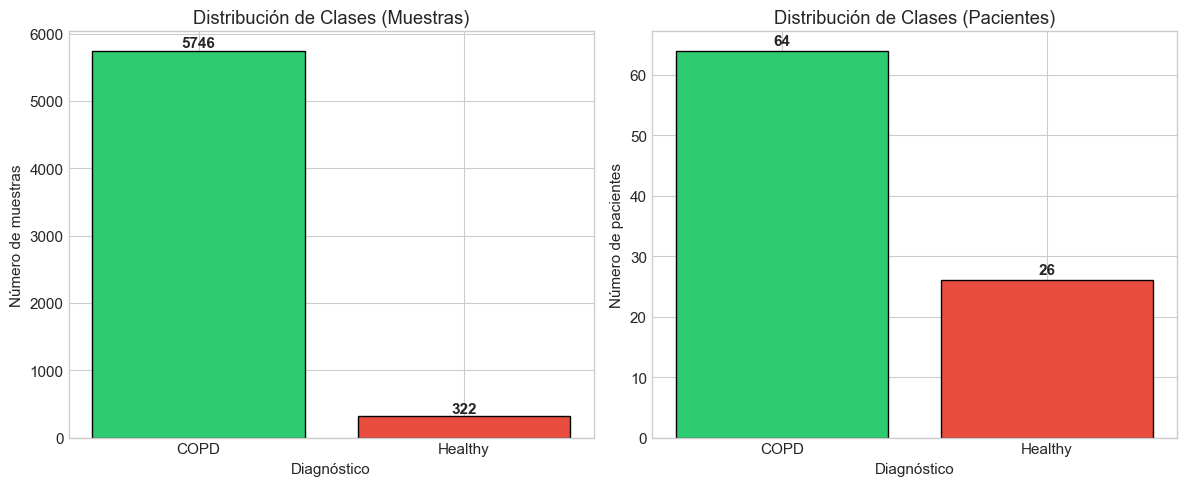


Ratio de desbalance: 17.84:1


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

class_counts = df['diagnosis'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('Número de muestras')
axes[0].set_title('Distribución de Clases (Muestras)')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

patient_class = df.groupby('patient_id')['diagnosis'].first().value_counts()
axes[1].bar(patient_class.index, patient_class.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Diagnóstico')
axes[1].set_ylabel('Número de pacientes')
axes[1].set_title('Distribución de Clases (Pacientes)')
for i, v in enumerate(patient_class.values):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}:1")


El análisis exploratorio revela un **desbalance severo de clases** (ratio 18:1 entre EPOC y pacientes sanos), que representa un desafío crítico para el aprendizaje automático. Este desbalance puede sesgar los modelos hacia la clase mayoritaria.

Se abordará este problema mediante estrategias de balanceo de datos, oversampling, y técnicas de regularización específicas, asegurando evaluaciones lo más robustas y equitativas posibles  del rendimiento de los modelos cuánticos y clásicos.


---

## 4. Preparación de los Datos

### 4.1 Extracción de Características

Los archivos de audio se procesan para extraer características acústicas basadas en los **Coeficientes Cepstrales en las Frecuencias de Mel (MFCC)**. Los MFCCs son ampliamente utilizados en el procesamiento de señales de audio porque capturan características espectrales relevantes del sonido de manera compacta.

Para cada ciclo respiratorio se extraen:

| Tipo de característica | Cantidad | Descripción |
|----------------------|----------|-------------|
| MFCC (media) | 13 | Media temporal de los 13 primeros coeficientes MFCC |
| MFCC (std) | 13 | Desviación estándar temporal de los MFCCs |
| Delta MFCC (media) | 13 | Media de la primera derivada temporal de los MFCCs |
| Delta MFCC (std) | 13 | Desviación estándar de la primera derivada |
| **Total** | **52** | Características por muestra |

Esta representación de 52 dimensiones captura tanto la información espectral estática como la dinámica temporal de cada ciclo respiratorio.

#### 4.1.1 Técnicas de Aumento de Datos de Audio

El módulo de extracción de características incorpora técnicas de **Data Augmentation** a nivel de señal de audio, permitiendo generar variaciones realistas de las grabaciones originales para enriquecer el conjunto de datos y mejorar la robustez de los modelos. Estas técnicas operan en el dominio temporal previo a la extracción de MFCCs y se basan en transformaciones comúnmente utilizadas en el procesamiento de señales de audio y voz.

| Técnica | Descripción | Parámetros |
|---------|-------------|------------|
| **Time Stretching** | Modifica la duración temporal de la señal sin alterar su contenido frecuencial (pitch). Utiliza la transformada de fase vocoder implementada en librosa. | `rate`: factor de estiramiento (>1 acelera, <1 ralentiza) |
| **Pitch Shifting** | Altera la frecuencia fundamental de la señal sin modificar su duración. Permite simular variaciones naturales en el tono de los sonidos respiratorios. | `n_steps`: semitonos de desplazamiento (positivo o negativo) |
| **Adición de Ruido** | Inyecta ruido blanco gaussiano a la señal para simular condiciones de grabación imperfectas y mejorar la generalización del modelo. | `noise_factor`: amplitud relativa del ruido añadido |

Formalmente, la adición de ruido se define como:

$$
x_{aug}(t) = x(t) + \alpha \cdot \mathcal{N}(0, \sigma^2)
$$

donde $x(t)$ es la señal original, $\alpha$ es el factor de ruido y $\mathcal{N}(0, \sigma^2)$ representa ruido blanco gaussiano con $\sigma = \max(|x(t)|)$.

Estas técnicas de augmentation están disponibles en el extractor de características (`AudioFeatureExtractor`) y pueden aplicarse de forma individual o combinada mediante el método `augment_audio()`, que genera múltiples versiones aumentadas de cada muestra original.

> **Nota:** Tras experimentación preliminar, estas técnicas de aumento de datos a nivel de audio no fueron incorporadas en el pipeline final, dado que no demostraron mejoras significativas en el rendimiento de los modelos. Se optó por emplear únicamente SMOTE (sección 4.4) para el tratamiento del desbalance de clases en el espacio de características.

### 4.2 Reducción de Dimensionalidad

Los simuladores cuánticos actuales enfrentan limitaciones significativas de escalabilidad. El número de qubits determina la dimensión del espacio de Hilbert, que crece exponencialmente ($2^n$ para $n$ qubits). Simular clásicamente un circuito de 8 qubits requiere manipular vectores de 256 dimensiones, mientras que 20 qubits ya serían imprácticos (más de 1 millón de dimensiones).

Por esta razón, se aplica **Análisis de Componentes Principales (PCA)** para reducir las 52 características originales a 8 componentes principales, que corresponderán al número de qubits del circuito cuántico. Esta reducción se justifica por:

1. **Limitaciones computacionales**: 8 qubits es un compromiso práctico entre expresividad y tiempo de simulación.
2. **Preservación de información**: Las primeras componentes principales capturan la mayor parte de la varianza de los datos.
3. **Regularización implícita**: La reducción de dimensionalidad puede ayudar a evitar el sobreajuste.

### 4.3 División de Datos por Pacientes

Un aspecto crítico en el análisis de datos médicos es evitar la **fuga de información (data leakage)**. En este dataset, cada paciente tiene múltiples ciclos respiratorios. Si dividiéramos los datos aleatoriamente, podríamos tener ciclos del mismo paciente tanto en el conjunto de entrenamiento como en el de test, lo que produciría una estimación optimista e irreal del rendimiento.

Para garantizar una evaluación rigurosa, se implementa una **división estratificada por pacientes**:

- Todos los ciclos respiratorios de un paciente pertenecen exclusivamente al conjunto de entrenamiento O al de test.
- Se mantiene aproximadamente la proporción de clases en ambos conjuntos.
- Se utiliza una partición 80% entrenamiento / 20% test.

Este enfoque simula el escenario real en el que el modelo debe clasificar a pacientes nuevos que no ha visto durante el entrenamiento.


In [5]:
from src.data.splitter import StratifiedPatientSplitter
from src.features.reducer import DimensionalityReducer

feature_cols = [c for c in df.columns if 'mfcc' in c]

splitter = StratifiedPatientSplitter(test_size=0.2, random_state=RANDOM_STATE)
train_df, test_df = splitter.split_dataframe(df)

split_info = splitter.get_patient_split_info(df)
print("=" * 60)
print("DIVISIÓN DE DATOS POR PACIENTES")
print("=" * 60)
print(f"Pacientes en entrenamiento: {split_info['train_patients']}")
print(f"Pacientes en test: {split_info['test_patients']}")
print(f"Muestras en entrenamiento: {split_info['train_samples']}")
print(f"Muestras en test: {split_info['test_samples']}")
print(f"\nDistribución de clases (entrenamiento): {split_info['train_class_distribution']}")
print(f"Distribución de clases (test): {split_info['test_class_distribution']}")


DIVISIÓN DE DATOS POR PACIENTES
Pacientes en entrenamiento: 73
Pacientes en test: 17
Muestras en entrenamiento: 5080
Muestras en test: 988

Distribución de clases (entrenamiento): {1: 4855, 0: 225}
Distribución de clases (test): {1: 891, 0: 97}


In [6]:
X_train_full = train_df[feature_cols].values
X_test_full = test_df[feature_cols].values
y_train = train_df['label'].values
y_test = test_df['label'].values

reducer = DimensionalityReducer(n_components=N_QUBITS)
X_train = reducer.fit_transform(X_train_full)
X_test = reducer.transform(X_test_full)

reducer.print_summary()



Dimensionality Reduction Summary
Input dimensions: 52
Output dimensions: 8
Total explained variance: 0.6675

Variance by component:
  PC1: 0.3013 (cumulative: 0.3013)
  PC2: 0.0912 (cumulative: 0.3925)
  PC3: 0.0764 (cumulative: 0.4689)
  PC4: 0.0509 (cumulative: 0.5198)
  PC5: 0.0430 (cumulative: 0.5628)
  PC6: 0.0403 (cumulative: 0.6031)
  PC7: 0.0340 (cumulative: 0.6371)
  PC8: 0.0303 (cumulative: 0.6675)



### 4.4 Tratamiento del Desbalance de Clases

#### El problema del desbalance

El conjunto de datos presenta un desbalance severo entre clases, con una proporción aproximada de **18:1** entre pacientes con EPOC y sujetos sanos. Este tipo de desbalance es especialmente problemático en contextos de aprendizaje supervisado, ya que puede inducir modelos sesgados hacia la clase mayoritaria y generar métricas de rendimiento artificialmente optimistas. La literatura más reciente proponen enfoques de **data augmentation**, permitiendo mejorar la representatividad de la clase minoritaria sin sacrificar capacidad de generalización.

#### 4.4.1 SMOTE (Synthetic Minority Over-sampling Technique)

Dentro de las técnicas de aumento de datos, se emplea SMOTE (Chawla et al., 2002), un método de sobremuestreo sintético que genera nuevas muestras de la clase minoritaria mediante interpolación lineal entre observaciones existentes y sus vecinos más cercanos en el espacio de características. Formalmente, una nueva muestra sintética se construye como:

$$
x_{nuevo} = x_i + \lambda \cdot (x_{nn} - x_i)
$$

donde $x_i$ representa una muestra de la clase minoritaria, $x_{nn}$ es uno de sus $k$ vecinos más cercanos pertenecientes a la misma clase y $\lambda \in [0,1]$ es un coeficiente aleatorio que controla el grado de interpolación. 



In [7]:
from src.features.balancing import FeatureBalancer
from sklearn.model_selection import train_test_split

balancer = FeatureBalancer(random_state=RANDOM_STATE)

print("=" * 60)
print("ANTES DE SMOTE - Distribución de clases")
print("=" * 60)
balancer.print_balance_report(y_train, title="Original Training Data")

# Apply SMOTE to balance classes
X_train_balanced, y_train_balanced = balancer.apply_smote(
    X_train, y_train,
    sampling_strategy='minority',  # Only oversample minority class
    k_neighbors=5
)

print("=" * 60)
print("DESPUÉS DE SMOTE - Distribución de clases")
print("=" * 60)
balancer.print_balance_report(y_train_balanced, title="Balanced Training Data")




if len(X_train_balanced) > N_SAMPLES_QSVM:
    X_train_qsvm, _, y_train_qsvm, _ = train_test_split(
        X_train_balanced, y_train_balanced, 
        train_size=N_SAMPLES_QSVM, 
        stratify=y_train_balanced, 
        random_state=RANDOM_STATE
    )
else:
    X_train_qsvm, y_train_qsvm = X_train_balanced, y_train_balanced

if len(X_train_balanced) > N_SAMPLES_QNN:
    X_train_qnn, _, y_train_qnn, _ = train_test_split(
        X_train_balanced, y_train_balanced, 
        train_size=N_SAMPLES_QNN, 
        stratify=y_train_balanced, 
        random_state=RANDOM_STATE
    )
else:
    X_train_qnn, y_train_qnn = X_train_balanced, y_train_balanced

print("\n" + "=" * 60)
print("CONJUNTOS DE DATOS PREPARADOS (BALANCEADOS)")
print("=" * 60)
print(f"Entrenamiento completo original: {X_train.shape}")
print(f"Entrenamiento balanceado: {X_train_balanced.shape}")
print(f"Entrenamiento QSVM (balanced): {X_train_qsvm.shape} - Healthy: {(y_train_qsvm==0).sum()}, COPD: {(y_train_qsvm==1).sum()}")
print(f"Entrenamiento QNN/Híbrido (balanced): {X_train_qnn.shape} - Healthy: {(y_train_qnn==0).sum()}, COPD: {(y_train_qnn==1).sum()}")
print(f"Test (sin modificar): {X_test.shape}")

ANTES DE SMOTE - Distribución de clases

Original Training Data
Total samples: 5080
Number of classes: 2

Class distribution:
  Class 0: 225 samples (4.4%)
  Class 1: 4855 samples (95.6%)

Imbalance ratio: 21.58:1
Minority class: 0 (4.4%)

DESPUÉS DE SMOTE - Distribución de clases

Balanced Training Data
Total samples: 9710
Number of classes: 2

Class distribution:
  Class 0: 4855 samples (50.0%)
  Class 1: 4855 samples (50.0%)

Imbalance ratio: 1.00:1
Minority class: 0 (50.0%)


CONJUNTOS DE DATOS PREPARADOS (BALANCEADOS)
Entrenamiento completo original: (5080, 8)
Entrenamiento balanceado: (9710, 8)
Entrenamiento QSVM (balanced): (600, 8) - Healthy: 300, COPD: 300
Entrenamiento QNN/Híbrido (balanced): (600, 8) - Healthy: 300, COPD: 300
Test (sin modificar): (988, 8)


## 5. Metodología

### 5.1 Pipeline de Clasificación

El proceso de clasificación sigue el siguiente pipeline:

<p align="center">
  <img src="../results/figures/flow.png" ">
</p>

<p align="center">
  <em>Pipeline de Clasificación.</em>
</p>


### 5.2 Métricas de Evaluación

En el contexto médico, la selección de métricas de evaluación es crítica y debe considerar las implicaciones clínicas de los diferentes tipos de errores. Aunque existen diversas métricas como Accuracy, Precision o F1-Score, en aplicaciones médicas la **Sensibilidad (Recall)** cobra una importancia fundamental.

La **Sensibilidad** mide la capacidad del modelo para detectar correctamente los casos positivos (enfermos), evitando los falsos negativos. Un falso negativo en este contexto significaría no detectar a un paciente que realmente padece la enfermedad, lo cual puede tener consecuencias graves al retrasar el tratamiento. Por el contrario, un falso positivo (derivar a un sano para pruebas adicionales) es menos crítico.

Normalmente, en datasets médicos, nos enfrentamos a un problema de clases desbalanceadas con muy pocos casos de la enfermedad (clase positiva) frente a muchos casos sanos. Sin embargo, en este trabajo **la situación es diferente** (contamos con suficientes datos de la enfermedad respecto a sanos).

Para la codificación de las variables, se ha establecido:
- **Clase Negativa (0):** Healthy (Sanos)
- **Clase Positiva (1):** COPD (Enfermos)

### 5.3 Configuración de Hiperparámetros

Los hiperparámetros de los modelos cuánticos se seleccionan considerando las limitaciones de simulación clásica y las recomendaciones en los diferentes notebooks de la asignatura.

### 5.4 Técnicas de Regularización y Control de Overfitting

El sobreajuste (overfitting) es un problema particularmente relevante en nuestro problema de clasificación debido al desbalance y naturaleza de los datos.

Para mitigar estos problemas, se implementan, además de las anteriormente mencionadas, las siguientes técnicas:

#### 5.4.1 Early Stopping

Detiene el entrenamiento cuando el rendimiento en validación deja de mejorar, evitando que el modelo se ajuste excesivamente a los datos de entrenamiento.

#### 5.4.2 Regularización por Dropout

En el modelo híbrido, el dropout desactiva aleatoriamente neuronas durante el entrenamiento.

#### 5.4.3 Ponderación de Clases

Para el desbalance de clases, se utilizan pesos inversamente proporcionales a la frecuencia de cada clase(únicamente cuando se entrena la SVM clásica con todo el conjunto de datos):

```python
class_weight = {0: n_total / (2 * n_healthy), 
                1: n_total / (2 * n_copd)}
```


---

## 6. Modelos de Clasificación

### 6.1 Baseline Clásico: Support Vector Machine

Como punto de referencia para evaluar el rendimiento de los modelos cuánticos, se implementa primero un clasificador SVM clásico con kernel RBF (Radial Basis Function). Este modelo representa el estado del arte en clasificación para datasets de tamaño moderado y sirve como benchmark realista.

El kernel RBF se define como:

$$K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)$$

donde $\gamma$ es un hiperparámetro que controla la influencia de cada muestra de entrenamiento.


In [22]:
from src.models.classical import ClassicalSVM
from src.evaluation.metrics import MedicalMetrics

svm_classical = ClassicalSVM(kernel='rbf', C=0.1, class_weight='balanced')
svm_classical.fit(X_train, y_train)

y_pred_svm = svm_classical.predict(X_test)
y_prob_svm = svm_classical.predict_proba(X_test)[:, 1]

metrics_svm = MedicalMetrics(y_test, y_pred_svm, y_prob_svm)
metrics_svm.print_report("SVM Clásico (RBF)")


Classical SVM trained in 3.36 seconds

Classification Report: SVM Clásico (RBF)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          92          5
         COPD         158        733

Metrics:
  Accuracy       : 0.8350
  Sensitivity    : 0.8227
  Specificity    : 0.9485
  Precision      : 0.9932
  NPV            : 0.3680
  F1-Score       : 0.8999
  AUC-ROC        : 0.9524

Interpretation:
  - Correctly identified 82.3% of COPD patients
  - Correctly identified 94.8% of Healthy patients



### 6.2 Quantum Support Vector Machine (QSVM)

El QSVM utiliza un **kernel cuántico** para medir la similitud entre pares de datos. La idea principal consiste en mapear datos clásicos a un espacio de Hilbert mediante un **circuito cuántico**, y emplear dicho producto interno dentro de la formulación dual del SVM.


#### Feature map utilizado

En este trabajo se emplea un **feature map basado en codificación en ángulo**, que permite implementar el kernel cuántico de forma eficiente mediante rotaciones dependientes de los datos.


In [23]:
from src.models.qsvm import QuantumKernelSVM
import pennylane as qml

# QSVM with balanced data from SMOTE
qsvm = QuantumKernelSVM(
    n_qubits=N_QUBITS,
    feature_map='angle',             
    C=0.1,                           # Regularization strength
    class_weight='balanced'          # Additional class weighting
)

print(f"Training QSVM with {len(y_train_qsvm)} balanced samples")
print(f"  Healthy: {(y_train_qsvm==0).sum()}, COPD: {(y_train_qsvm==1).sum()}")
print("\nEstructura del circuito kernel cuántico:")
qsvm.draw_circuit()


Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Lightning CPU not available: cannot import name 'LinearCombination' from 'pennylane.ops' (d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\venv\lib\site-packages\pennylane\ops\__init__.py)
Using default.qubit device (classical simulation)
QSVM using device: <default.qubit device (wires=8) at 0x1cd0997fa00>
Training QSVM with 600 balanced samples
  Healthy: 300, COPD: 300

Estructura del circuito kernel cuántico:
0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M0)†─┤  Probs
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
3: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
4: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
5: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
6: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
7: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M0)†─┤  Probs

M0 = 
[0. 0. 0. 0. 0

In [24]:
qsvm.fit(X_train_qsvm, y_train_qsvm)

y_pred_qsvm = qsvm.predict(X_test, show_progress=True)
y_prob_qsvm = qsvm.predict_proba(X_test, show_progress=False)[:, 1]

metrics_qsvm = MedicalMetrics(y_test, y_pred_qsvm, y_prob_qsvm)
metrics_qsvm.print_report("QSVM (Quantum Kernel)")


Training QSVM with 600 samples
QSVM trained in 1062.26 seconds

Classification Report: QSVM (Quantum Kernel)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          89          8
         COPD         598        293

Metrics:
  Accuracy       : 0.3866
  Sensitivity    : 0.3288
  Specificity    : 0.9175
  Precision      : 0.9734
  NPV            : 0.1295
  F1-Score       : 0.4916
  AUC-ROC        : 0.7357

Interpretation:
  - Correctly identified 32.9% of COPD patients
  - Correctly identified 91.8% of Healthy patients



### 6.3 Red Neuronal Cuántica (QNN)

La Red Neuronal Cuántica (QNN) representa un enfoque diferente al QSVM: en lugar de usar un kernel fijo, utiliza un circuito cuántico parametrizado cuyos parámetros se optimizan durante el entrenamiento mediante descenso de gradiente.

#### Arquitectura del Circuito

> Nota: Todos los parámetros (\# qubits, capas, forma variacional) se eligieron de forma **experimental** con orientación en el contenido de los notebooks prácticos de la asignatura, considerando las limitaciones físicas del hardware y la complejidad del problema.




In [ ]:
from src.models.qnn import QuantumNeuralNetwork

# Class weights for additional balancing (now data is already SMOTE-balanced)
class_weights = {0: len(y_train_qnn) / (2 * (y_train_qnn == 0).sum()),
                 1: len(y_train_qnn) / (2 * (y_train_qnn == 1).sum())}

qnn = QuantumNeuralNetwork(
    n_qubits=N_QUBITS,
    n_layers=2,                      # Reduced complexity
    learning_rate=0.005,             # Conservative learning rate
    epochs=100,
    class_weight=class_weights,
    early_stopping_patience=10,      # Early stopping
    validation_split=0.2             # Use 20% for validation
)

print("Estructura del circuito QNN:")
qnn.draw_circuit()


Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Lightning CPU not available: cannot import name 'LinearCombination' from 'pennylane.ops' (d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\venv\lib\site-packages\pennylane\ops\__init__.py)
Using default.qubit device (classical simulation)
QNN using device: <default.qubit device (wires=8) at 0x1cd3aa866e0>
Estructura del circuito QNN:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <𝓗(M2)>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
3: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
4: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
5: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
6: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
7: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤         

M0 = 
[0. 0.

In [ ]:
qnn.fit(X_train_qnn, y_train_qnn, verbose=True)


Using 480 samples for training, 120 for validation


Training QNN: 100%|██████████| 100/100 [1:36:53<00:00, 58.13s/it, loss=0.2436, val_loss=0.2361, grad=8.51e-03]

Restored best weights from epoch with val_loss: 0.2361
QNN trained in 5813.23 seconds
Final training loss: 0.2436
Best validation loss: 0.2361
Final gradient norm: 8.51e-03


QuantumNeuralNetwork(name='Quantum Neural Network')

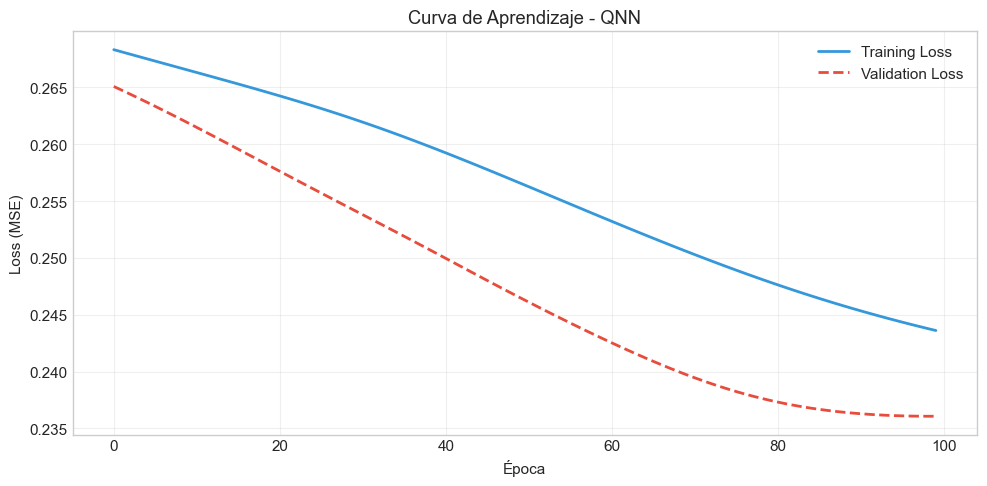

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training loss
ax.plot(qnn.get_training_history(), linewidth=2, color='#3498db', label='Training Loss')

# Plot validation loss if available
val_history = qnn.get_validation_history()
if val_history:
    ax.plot(val_history, linewidth=2, color='#e74c3c', linestyle='--', label='Validation Loss')
    
    # Mark early stopping point if triggered
    if qnn.stopped_epoch is not None:
        ax.axvline(x=qnn.stopped_epoch, color='#2ecc71', linestyle=':', 
                   linewidth=2, label=f'Early Stop (epoch {qnn.stopped_epoch})')

ax.set_xlabel('Época')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Curva de Aprendizaje - QNN')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'qnn_training.png', dpi=150, bbox_inches='tight')
plt.show()


In [26]:
from src.evaluation.metrics import MedicalMetrics

y_pred_qnn = qnn.predict(X_test)
y_prob_qnn = qnn.predict_proba(X_test)[:, 1]

metrics_qnn = MedicalMetrics(y_test, y_pred_qnn, y_prob_qnn)
metrics_qnn.print_report("QNN (Quantum Neural Network)")



Classification Report: QNN (Quantum Neural Network)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          54         43
         COPD         487        404

Metrics:
  Accuracy       : 0.4636
  Sensitivity    : 0.4534
  Specificity    : 0.5567
  Precision      : 0.9038
  NPV            : 0.0998
  F1-Score       : 0.6039
  AUC-ROC        : 0.5086

Interpretation:
  - Correctly identified 45.3% of COPD patients
  - Correctly identified 55.7% of Healthy patients



### 6.4 Red Híbrida Cuántico-Clásica

Las redes híbridas combinan lo mejor de ambos mundos: la capacidad de las redes neuronales clásicas para el preprocesamiento y postprocesamiento de datos, con el potencial de las capas cuánticas para capturar correlaciones complejas.

#### Arquitectura

La red híbrida implementada sigue la estructura:

```
Input (8D) → Linear → ReLU → Quantum Layer → Linear → Output
    ↓          ↓        ↓          ↓            ↓         ↓
  [8 feat]  [8→n_q]   act    [n_qubits]     [n_q→1]   [logit]
                           StronglyEnt     
```

**Preprocesamiento clásico**: Una capa lineal con activación ReLU que transforma las características de entrada al número de qubits.

**Capa cuántica**: Un circuito con AngleEmbedding + StronglyEntanglingLayers. Devuelve los valores esperados de $\sigma_Z$ en cada qubit.

**Postprocesamiento clásico**: Una capa lineal simple que produce el logit final para la clasificación.

#### Entrenamiento End-to-End

El modelo completo se entrena de forma conjunta usando PyTorch y PennyLane con Binary Cross-Entropy Loss. Los gradientes fluyen desde la función de pérdida a través de las capas clásicas y cuánticas, permitiendo que el circuito cuántico se adapte al problema específico.


In [ ]:
from src.models.hybrid import HybridQuantumClassifier

pos_weight = (y_train_qnn == 0).sum() / (y_train_qnn == 1).sum()

hybrid = HybridQuantumClassifier(
    input_dim=N_QUBITS,
    n_qubits=8,                      
    n_layers=2,                      
    learning_rate=0.01,              
    epochs=50,
    batch_size=32,
    pos_weight=pos_weight,
    early_stopping_patience=10,     
)

print(f"\nArquitectura de la red híbrida:")
print(f"Parámetros totales: {hybrid.count_parameters()}")


🖥️ PyTorch using: cuda
   GPU: NVIDIA GeForce RTX 3060
   CUDA Version: 12.1
   Using default.qubit for quantum layer
⚛️ Quantum device: <default.qubit device (wires=8) at 0x1cd09c5e920>

Arquitectura de la red híbrida:
Parámetros totales: 1081


In [17]:
hybrid.fit(X_train_qnn, y_train_qnn, validation_split=0.2, verbose=True)


Using 480 samples for training, 120 for validation


Training Hybrid (cuda):  50%|█████     | 25/50 [10:03<10:03, 24.15s/it, loss: 0.2759, val_loss: 0.3694]


🛑 Early stopping triggered at epoch 25. Best val_loss: 0.3116
Restored best weights from epoch with val_loss: 0.3116
Hybrid model trained in 603.82 seconds
Final training loss: 0.2585
Best validation loss: 0.3116


HybridQuantumClassifier(name='Hybrid Quantum Classifier')

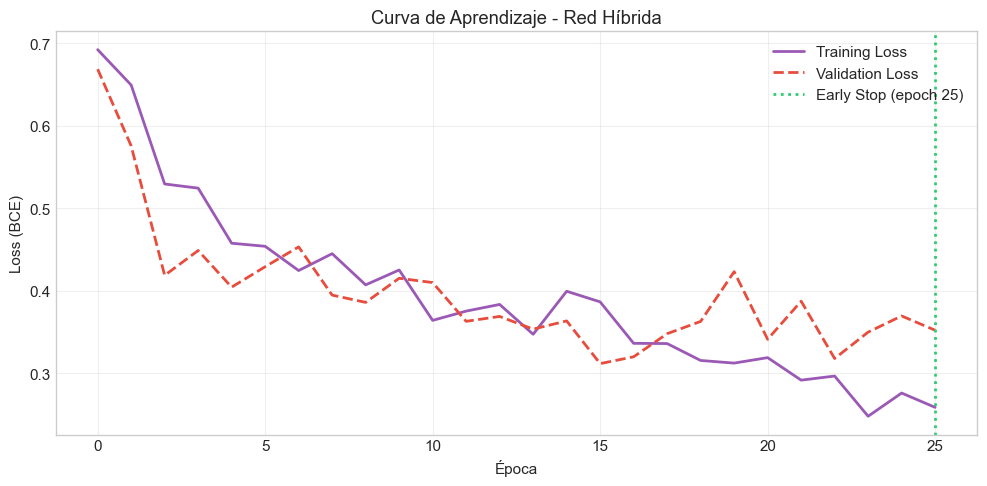

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

history = hybrid.get_training_history()
ax.plot(history['loss'], linewidth=2, color='#9b59b6', label='Training Loss')

if history['val_loss']:
    ax.plot(history['val_loss'], linewidth=2, color='#e74c3c', linestyle='--', label='Validation Loss')
    
    if hybrid.stopped_epoch is not None:
        ax.axvline(x=hybrid.stopped_epoch, color='#2ecc71', linestyle=':', 
                   linewidth=2, label=f'Early Stop (epoch {hybrid.stopped_epoch})')

ax.set_xlabel('Época')
ax.set_ylabel('Loss (BCE)')
ax.set_title('Curva de Aprendizaje - Red Híbrida')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'hybrid_training.png', dpi=150, bbox_inches='tight')
plt.show()


In [19]:
y_pred_hybrid = hybrid.predict(X_test)
y_prob_hybrid = hybrid.predict_proba(X_test)[:, 1]

metrics_hybrid = MedicalMetrics(y_test, y_pred_hybrid, y_prob_hybrid)
metrics_hybrid.print_report("Red Híbrida Cuántico-Clásica")



Classification Report: Red Híbrida Cuántico-Clásica

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          87         10
         COPD         207        684

Metrics:
  Accuracy       : 0.7804
  Sensitivity    : 0.7677
  Specificity    : 0.8969
  Precision      : 0.9856
  NPV            : 0.2959
  F1-Score       : 0.8631
  AUC-ROC        : 0.9177

Interpretation:
  - Correctly identified 76.8% of COPD patients
  - Correctly identified 89.7% of Healthy patients



---

## 7. Resultados

### 7.1 Comparativa de Métricas

A continuación se presenta una comparativa exhaustiva del rendimiento de todos los modelos evaluados.


In [28]:
from src.evaluation.metrics import compare_models, print_comparison_table

all_results = {
    "SVM Clásico": metrics_svm,
    "QSVM": metrics_qsvm,
    "QNN": metrics_qnn,
    "Híbrido": metrics_hybrid
}

print_comparison_table(all_results)



Model Comparison
             Accuracy  Sensitivity  Specificity  Precision       NPV  F1-Score   AUC-ROC
Model                                                                                   
SVM Clásico  0.835020     0.822671     0.948454   0.993225  0.368000  0.899939  0.952411
QSVM         0.386640     0.328844     0.917526   0.973422  0.129549  0.491611  0.735661
QNN          0.463563     0.453423     0.556701   0.903803  0.099815  0.603886  0.508591
Híbrido      0.780364     0.767677     0.896907   0.985591  0.295918  0.863091  0.917665

Best models:
  Accuracy: SVM Clásico (0.8350)
  Sensitivity: SVM Clásico (0.8227)
  Specificity: SVM Clásico (0.9485)
  Precision: SVM Clásico (0.9932)
  NPV: SVM Clásico (0.3680)
  F1-Score: SVM Clásico (0.8999)
  AUC-ROC: SVM Clásico (0.9524)



In [29]:
comparison_df = compare_models(all_results)
comparison_df['Training Time (s)'] = [
    svm_classical.training_time,
    qsvm.training_time,
    qnn.training_time,
    hybrid.training_time
]
comparison_df['Training Samples'] = [len(X_train), len(X_train_qsvm), len(X_train_qnn), len(X_train_qnn)]

comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv')
print("Resultados guardados en:", RESULTS_DIR / 'model_comparison.csv')


Resultados guardados en: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\results\model_comparison.csv


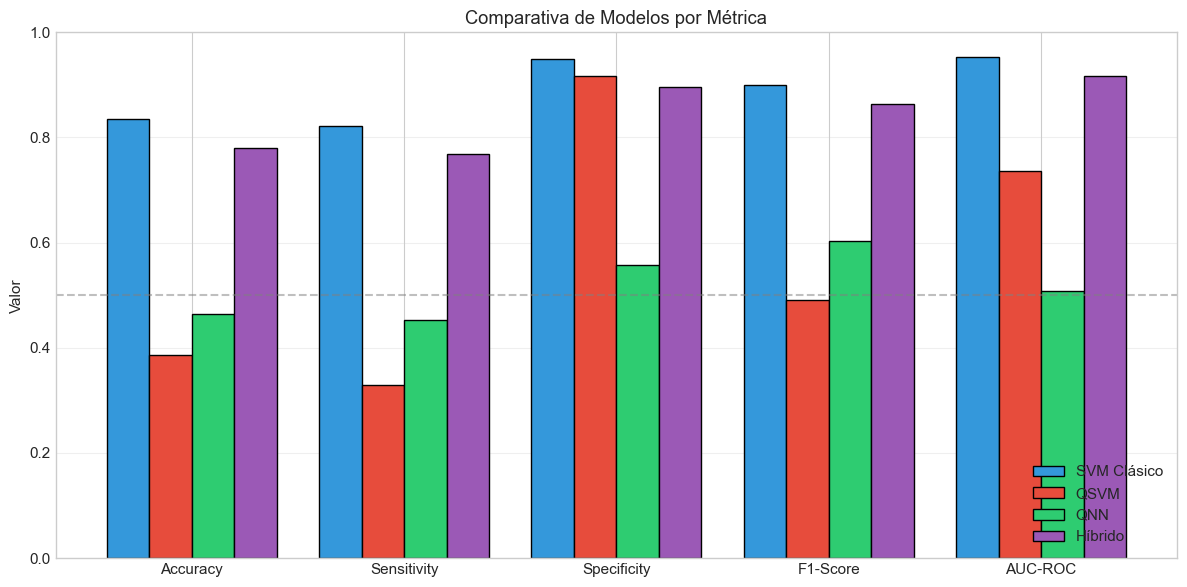

In [30]:
metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'F1-Score', 'AUC-ROC']
models = list(all_results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, (model, color) in enumerate(zip(models, colors)):
    values = [all_results[model].get_all_metrics()[m] for m in metrics_to_plot]
    bars = ax.bar(x + i * width, values, width, label=model, color=color, edgecolor='black')

ax.set_ylabel('Valor')
ax.set_title('Comparativa de Modelos por Métrica')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline aleatorio')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.2 Matrices de Confusión


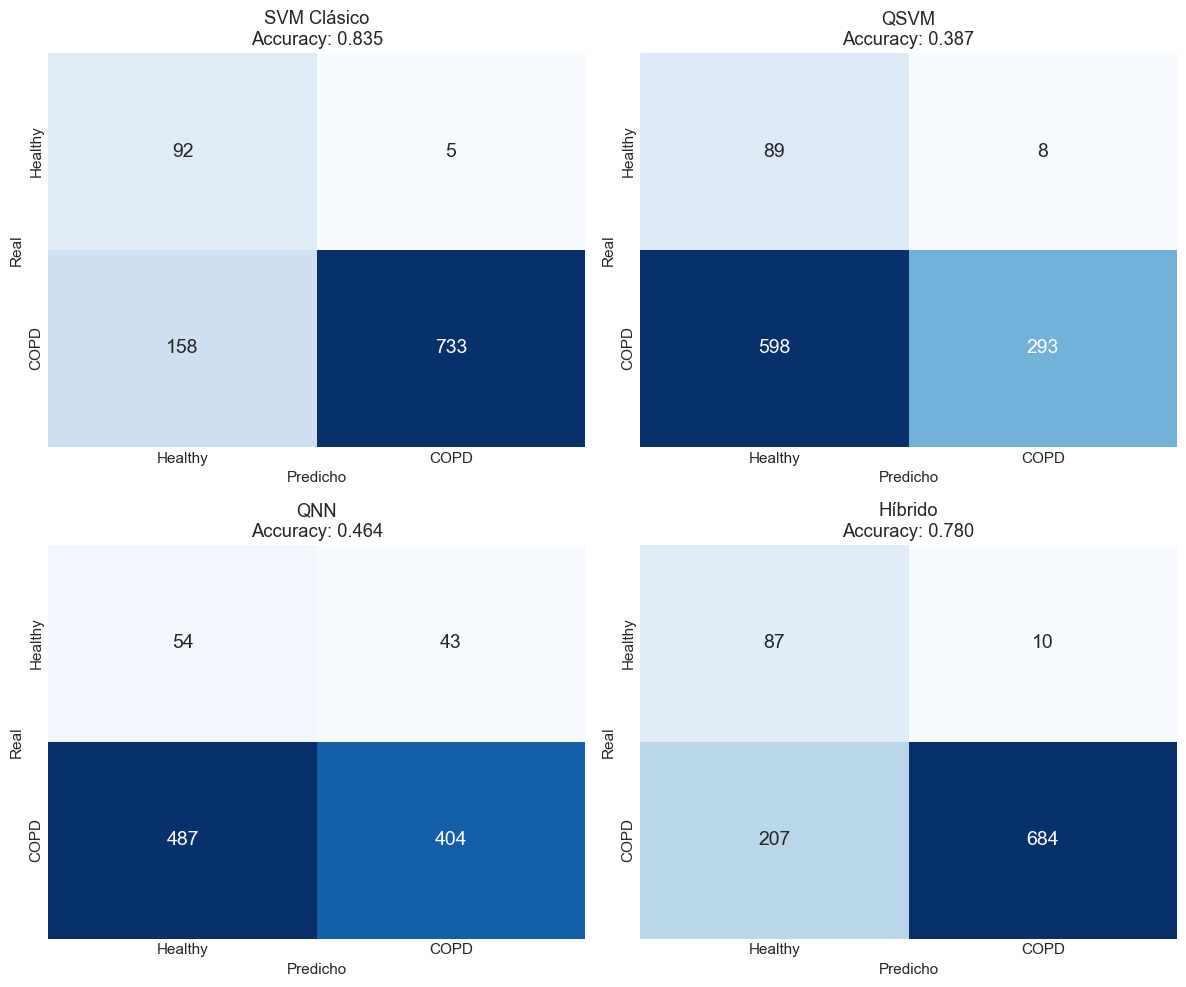

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (model_name, metrics) in enumerate(all_results.items()):
    cm = metrics.get_confusion_matrix()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar=False, annot_kws={'size': 14})
    axes[idx].set_xlabel('Predicho')
    axes[idx].set_ylabel('Real')
    axes[idx].set_title(f'{model_name}\nAccuracy: {metrics.accuracy:.3f}')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.3 Curvas ROC


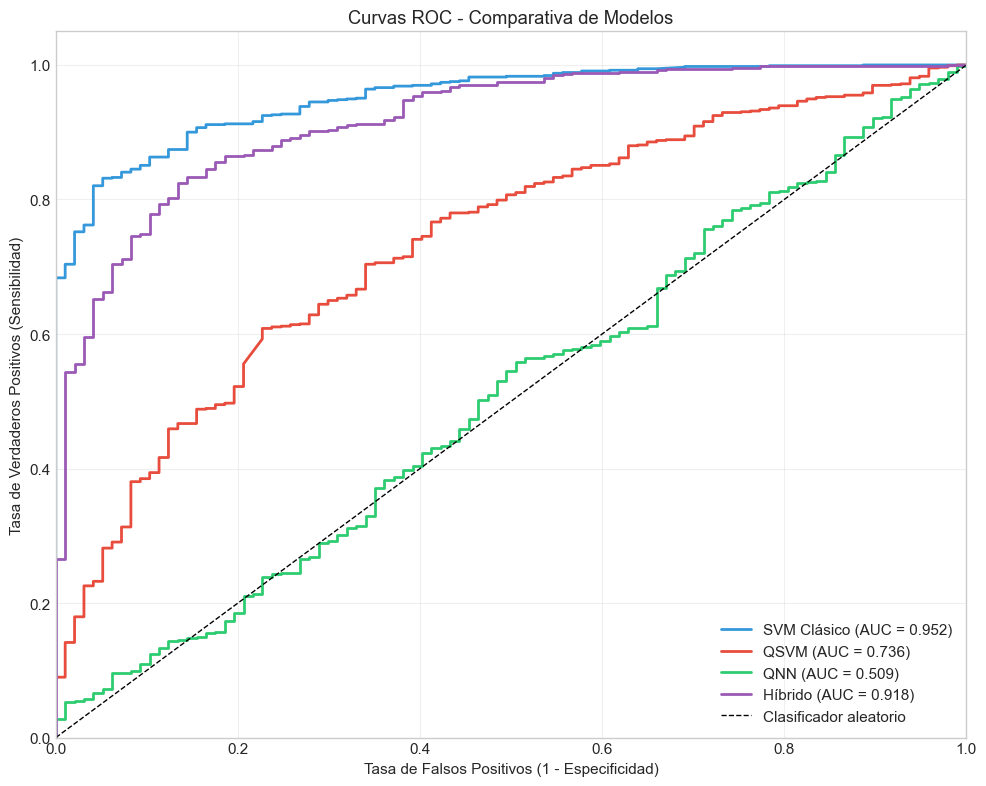

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

for (model_name, metrics), color in zip(all_results.items(), colors):
    if metrics.y_prob is not None:
        fpr, tpr, _ = metrics.get_roc_curve()
        ax.plot(fpr, tpr, linewidth=2, color=color,
                label=f'{model_name} (AUC = {metrics.auc_roc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax.set_title('Curvas ROC - Comparativa de Modelos')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.4 Análisis de Tiempos de Entrenamiento


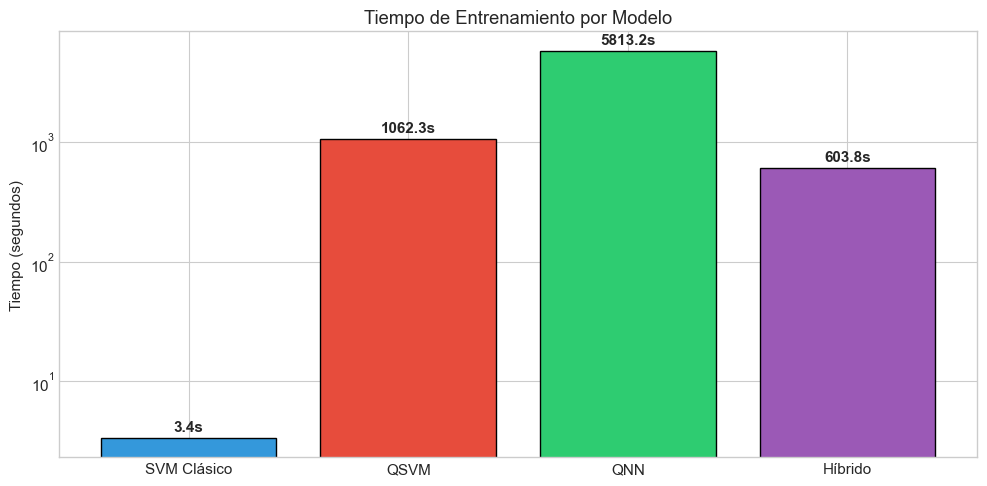


Resumen de tiempos:
  SVM Clásico: 3.36 segundos
  QSVM: 1062.26 segundos
  QNN: 5813.23 segundos
  Híbrido: 603.82 segundos


In [33]:
times = {
    'SVM Clásico': svm_classical.training_time,
    'QSVM': qsvm.training_time,
    'QNN': qnn.training_time,
    'Híbrido': hybrid.training_time
}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(times.keys(), times.values(), color=colors, edgecolor='black')
ax.set_ylabel('Tiempo (segundos)')
ax.set_title('Tiempo de Entrenamiento por Modelo')
ax.set_yscale('log')

for bar, time in zip(bars, times.values()):
    height = bar.get_height()
    ax.annotate(f'{time:.1f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'training_times.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResumen de tiempos:")
for model, time in times.items():
    print(f"  {model}: {time:.2f} segundos")


---

## 8. Conclusiones

A partir de los resultados obtenidos y las visualizaciones generadas, se presenta la siguiente comparativa entre los modelos implementados.

### Comparativa de Rendimiento

Como se observa en la **Figura de Comparativa de Modelos por Métrica** y las **Curvas ROC**, el rendimiento de los cuatro modelos difiere sustancialmente:

| Modelo | Accuracy | Sensibilidad | Especificidad | F1-Score | AUC-ROC | Tiempo (s) |
|--------|----------|--------------|---------------|----------|---------|------------|
| SVM Clásico | 0.835 | 0.823 | 0.948 | 0.899 | 0.952 | 3.4 |
| QSVM | 0.387 | 0.329 | 0.918 | 0.492 | 0.736 | 1062.3 |
| QNN | 0.464 | 0.453 | 0.557 | 0.608 | 0.509 | 5813.2 |
| Híbrido | 0.780 | 0.768 | 0.897 | 0.867 | 0.918 | 603.8 |

**Observaciones principales:**

1. **El SVM clásico obtiene los mejores resultados** en todas las métricas, con un AUC-ROC de 0.952 que indica excelente capacidad discriminativa. Como se aprecia en su matriz de confusión, clasifica correctamente 92 de 97 pacientes sanos y 733 de 891 con EPOC.

2. **El modelo híbrido es el mejor enfoque cuántico**, alcanzando un AUC-ROC de 0.918 (solo 3.4 puntos por debajo del clásico). La combinación de capas clásicas (Dense) con la capa cuántica variacional permite aprovechar las fortalezas de ambos paradigmas.

3. **El QSVM presenta un comportamiento sesgado**: aunque tiene alta especificidad (0.918), su baja sensibilidad (0.329) indica que clasifica la mayoría de muestras como la clase mayoritaria (COPD). El kernel cuántico basado en AngleEmbedding no logra capturar adecuadamente la estructura de los datos.

4. **La QNN muestra rendimiento cercano al aleatorio** (AUC ≈ 0.5), lo que sugiere que el circuito variacional de 2 capas con 8 qubits no tiene suficiente expresividad, o que el optimizador Adam no encuentra un mínimo adecuado en 50 epochs.

### Análisis del Coste Computacional

La **Figura de Tiempos de Entrenamiento** evidencia el principal inconveniente de los métodos cuánticos simulados: el SVM clásico entrena en ~3 segundos, mientras que los modelos cuánticos requieren entre 10 minutos (híbrido) y 97 minutos (QNN). Esta diferencia de 3 órdenes de magnitud se debe a la simulación del espacio de Hilbert de $2^n$ dimensiones.

### Conclusión Final

Los resultados demuestran que, en el contexto actual de simulación clásica de circuitos cuánticos, **los métodos cuánticos puros (QSVM, QNN) no superan al baseline clásico** para este problema de clasificación de sonidos respiratorios. Sin embargo, **el modelo híbrido logra un rendimiento competitivo** (78% vs 83.5%), lo que sugiere que las arquitecturas que combinan componentes clásicos y cuánticos son la aproximación más prometedora en la era NISQ (Noisy Intermediate-Scale Quantum).

El desbalance severo del dataset (18:1) afecta especialmente a los modelos cuánticos, que muestran mayor dificultad para aprender patrones de la clase minoritaria incluso tras aplicar SMOTE. Esto indica que se requieren técnicas adicionales de regularización o arquitecturas más robustas al desbalance.

